# Setup

In [66]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [67]:
%matplotlib inline

In [68]:
import sys
sys.path.append('/home/imendoza/nbody-relaxed/')

import relaxed

from relaxed.plot_defaults import *

import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import sklearn
import scipy
import warnings
from tqdm import tqdm

import matplotlib as mpl
from sklearn.model_selection import train_test_split


from relaxed.analysis import get_mah, add_box_indices, alpha_analysis, vol_jacknife_err, get_an_from_am, get_a_from_t, get_t_from_a, diffmah_analysis
from relaxed.models import training_suite, prepare_datasets
from relaxed import halo_catalogs

In [69]:
# Data

mah_data = get_mah('m12', '../../output/', cutoff_missing=0.05, cutoff_particle=0.05)

# catalog
cat = mah_data['cat']
xoff = cat['x0']
cvir = cat['cvir']
eta = cat['eta']
spin = cat['spin']
voff = cat['v0']
q = cat['q']
ma = mah_data['ma']
ma_peak = mah_data['ma_peak']
am = mah_data['am']

scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, eta.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

(10000,) (10000,) (10000,) (10000, 100) (10000, 165) (165,) (100,)


In [70]:
# prepare catalog with all a_m
names = [f'am_{ii}' for ii in range(len(mass_bins))]
for ii in range(len(mass_bins)):
    cat.add_column(am[:, ii], name=names[ii])

In [71]:
# add box indices to cat for uncertainty purposes
add_box_indices(cat)

info = {
    'cvir_only': {'x': ('cvir', ), 'y': names, },
    'x0_only': {'x': ('x0', ), 'y': names, },
    'eta_only': {'x': ('eta', ), 'y': names, },
    'all': {'x':('cvir', 't/|u|', 'x0', 'spin', 'q'), 'y':names,},
}
datasets, cat_train, cat_test = prepare_datasets(cat, info)

In [72]:
# joint models
data ={
    'linear_cvir': {
        'xy': datasets['cvir_only']['train'], 'n_features': 1, 'n_targets': 100, 'model': 'linear',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
    'linear_x0': {
        'xy': datasets['x0_only']['train'], 'n_features': 1, 'n_targets': 100, 'model': 'linear',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
    'linear_eta': {
        'xy': datasets['eta_only']['train'], 'n_features': 1, 'n_targets': 100, 'model': 'linear',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
    'linear_all': {
        'xy': datasets['all']['train'], 'n_features': 5, 'n_targets': 100, 'model': 'linear',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
}
models = training_suite(data)

In [77]:
# get correlations from predictions 
from scipy.stats import spearmanr
corrs = {} 
sigmas_x ={}
dataset_names = ['cvir_only', 'x0_only', 'eta_only', 'all']
mdl_names  = ['linear_cvir', 'linear_x0', 'linear_eta', 'linear_all']
for dataset_names, mdl_name in zip(dataset_names, mdl_names):
    model = models[mdl_name]
    x_test, y_test = datasets[dataset_names]['test']
    y_pred = model.predict(x_test)
    corrs[mdl_name] = np.array([spearmanr(y_pred[:, jj], y_test[:, jj]).correlation for jj in range(y_pred.shape[1])])
    sigmas_x[mdl_name] = np.array([np.std(y_pred[:, jj] - y_test[:, jj]) / (np.sqrt(2)*np.std(y_test[:, jj])) 
                                   for jj in range(y_pred.shape[1])])


/home/imendoza/.cache/pypoetry/virtualenvs/nbody-relaxed-NAcJ5UAP-py3.8/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/imendoza/.cache/pypoetry/virtualenvs/nbody-relaxed-NAcJ5UAP-py3.8/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/imendoza/.cache/pypoetry/virtualenvs/nbody-relaxed-NAcJ5UAP-py3.8/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


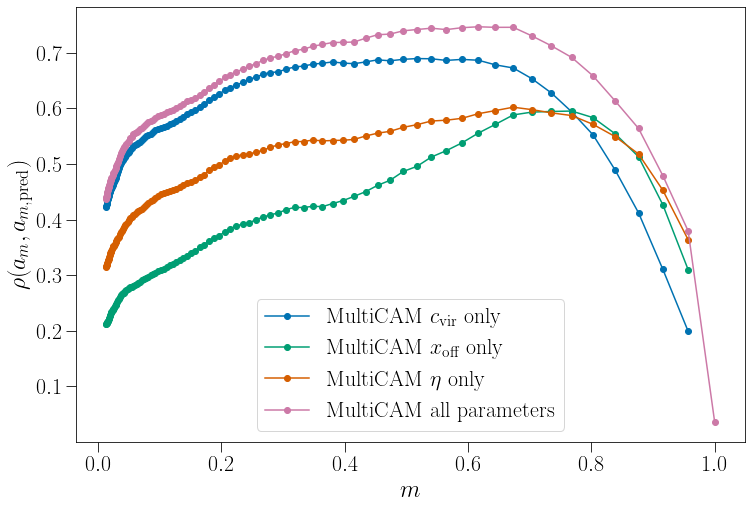

In [74]:
# plots 
plt.figure(figsize=(12, 8))
nice_names = [r'\rm MultiCAM $c_{\rm vir}$ only', 
              r'\rm MultiCAM $x_{\rm off}$ only',
              r'\rm MultiCAM $\eta$ only',
             r'\rm MultiCAM all parameters']
for nice_name, mdl_name in zip(nice_names, mdl_names):
    plt.plot(mass_bins, corrs[mdl_name], label=nice_name, marker='o')
plt.xlabel('$m$')
plt.ylabel('$\\rho(a_{m}, a_{m, \\rm{pred}})$')
plt.legend()

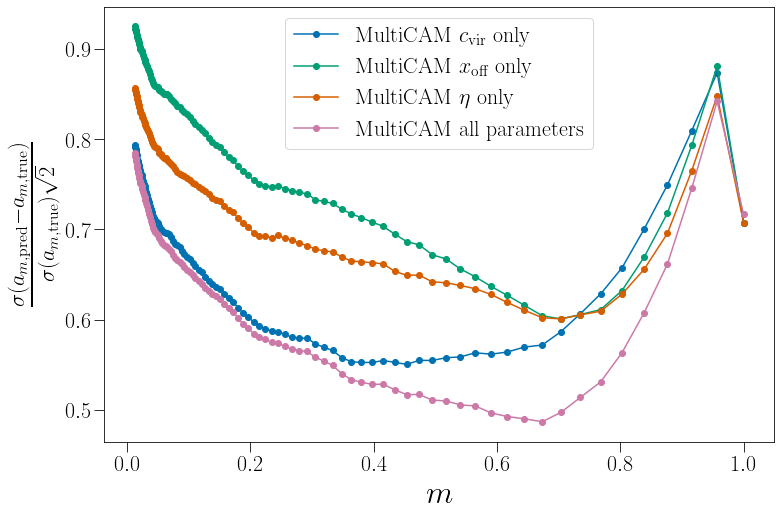

In [81]:
# plots 
plt.figure(figsize=(12, 8))
nice_names = [r'\rm MultiCAM $c_{\rm vir}$ only', 
              r'\rm MultiCAM $x_{\rm off}$ only',
              r'\rm MultiCAM $\eta$ only',
             r'\rm MultiCAM all parameters']
for nice_name, mdl_name in zip(nice_names, mdl_names):
    plt.plot(mass_bins, sigmas_x[mdl_name], label=nice_name, marker='o')
plt.xlabel('$m$', size=32)
plt.ylabel(r"$\frac{\sigma(a_{m, \rm pred} - a_{m, \rm true})}{ \sigma(a_{m, \rm true}) \sqrt{2}}$", size=32)
plt.legend()